# Logistic Regression: a Linear Model for Classification

**Objectives**:
1. Understand the **mathematical framework** behind logistic regression and its relationship to linear regression 
2. Work through a **practical application of logistic regression** to build comfort and know what to look for in EDA, understanding the benefits and limitations of the model  

In [1]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Logistic regression visualization utility function
def generate_logreg_vis(beta=-.05):
    
    # draw feature values and use beta to calculate predicted probability
    # of positive class for each feature value
    x = np.random.uniform(low=-1, high=1, size=150) * 100
    p = 1 / (1 + np.exp(-(beta*x))) # logistic regression function
    
    # plot predicted probs against the feature 
    plt.scatter(x, p)
    plt.title('Probability of Default vs. Credit Rating Score')
    plt.ylabel('Predicted Probability of Default')
    plt.xlabel('Credit Rating Score')
    
    # 50% probability threshold
    plt.gca().axhline(.5,c='k',ls='--',lw=1)

### Mathematical Framework

Let's start by understanding what we want from logistic regression, then work through the math of how to formulate the model. We have 2 goals -- 

1. Create a **linear model**, i.e. one where the relationship between the features and the target is driven by a linear combination $\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_p x_p$
2. Create a **probabilistic or soft classifier** binary model, i.e. one where $f(\vec{x}) = p$, with $p$ a probability between $0$ and $1$ for the positive class outcome.

Visually, the end result of a single-feature logistic regression model might look something like this, where the nonlinear S curve will be explained shortly--

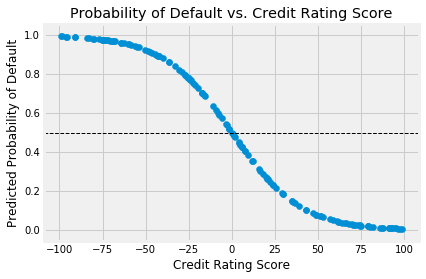

In [3]:
generate_logreg_vis()

Our first goal sounds exactly like linear regression, but for the problem that a linear regression / simple linear combination can give unconstrained predictions between $-\infty$ and $\infty$. So to meet both of our goals, we'll come up with a function that can **translate probability scale  back to linear combination scale**, i.e. convert numbers between $0$ and $1$ to numbers between $-\infty$ and $\infty$. 

This linking function turns out to be the **logit or log odds function**, which maps $p$ to $\log(\frac{p}{1-p})$, where $\frac{p}{1-p}$ is the odds in the conventional sense of betting (this ratio is where 2:1, 5:1, 10:1 odds etc. comes from). We can see why this linking function works by looking at the scale at each step of the transformation: 

$$Probability: p \in (0, 1)$$

$$Odds: \frac{p}{1-p} \in (0, \infty)$$

$$Log \ Odds: \log(\frac{p}{1-p}) \in (-\infty, \infty)$$

Below you can see a visualization of the 3 different scales -- on the left are the values we would predict, and on the right are the values we would express as a linear combination.

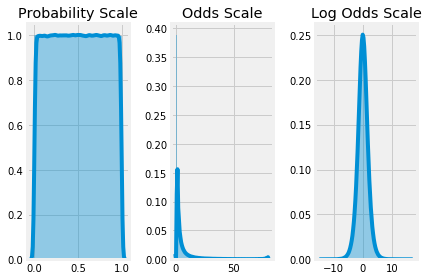

In [4]:
# draw random probabilities and convert to odds, log odds
probs = np.random.uniform(size=10000000)
odds = probs / (1 - probs)
log_odds = np.log(odds)

# plot distributions on a shared grid
fig, axs = plt.subplots(ncols=3)
sns.distplot(probs, ax=axs[0])
sns.distplot(odds[odds < 80], ax=axs[1]) # truncate extreme right tail for better visual
sns.distplot(log_odds, ax=axs[2])

axs[0].title.set_text('Probability Scale')
axs[1].title.set_text('Odds Scale')
axs[2].title.set_text('Log Odds Scale')
fig.tight_layout()

Now that we've seen how to translate probability scale to linear combination scale, we can define our logistic regression model by **reversing this process**, i.e. taking a linear combination to probability scale. It turns out that we can do this with the **sigmoid or logistic function** $\sigma (z) = \frac{1}{1+e^{-z}}$, the **inverse of the log odds function**, composing it with our linear combination to get the **logistic regression function**:

---

$$ f(\vec{x}) = \sigma (\beta_0 + \beta_1 x_1 + ... \beta_p x_p) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + ... \beta_p x_p)}} = p $$

---

We'll end up **fitting/training a logistic regression model** by choosing the coefficients $\beta_i$ that allow us to best describe our observed training data. Here "best described" means getting predicted probabilities as close to the actual target value for that sample as possible (i.e. low probability for a true $0$, high probability for a true $1$), and the coefficient selection process happens through an **optimization method like gradient descent**. 

For completeness, we can quickly confirm that $\sigma$ is actually the inverse of the log odds function:

$$ \sigma (\log(\frac{p}{1-p})) = \frac{1}{1+e^{-\log(\frac{p}{1-p})}}$$

$$ = \frac{1}{1 + \frac{1-p}{p}} $$

$$ = p $$

Now that we've worked through the math underlying logistic regression models, we can return to the *generate_logreg_vis* function defined at the beginning of this notebook. We can now understand what's happening in the code with the logistic regression function, and we can experiment with varying beta to build intuition.

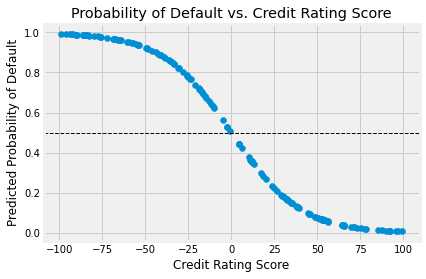

In [9]:
generate_logreg_vis(beta=-0.05)

---

**Exercise**: in the cell above, experiment with the coefficient (beta) in the logistic regression. What happens as you increase or decrease the magnitude of beta? What happens when you change its sign? Try to put what you see into words re: the relationship between credit score and probability of default described by the model.   

---


#### Precision Around Interpretation

As you can likely tell from working on the exercise, describing the relationship between a feature and the target is less intuitive here than it is for a simple linear regression (one unit increase in $x$ implies a 
$\beta$ increase in the predicted value $y$). This is because the **use of the sigmoid introduces a nonlinearity**, requiring us to know the current value predicted for $p$ before we can know the exact extremity of the effect that varying any feature $x$ has on that predicted $p$ (you can see this dependency in the visual immediately above).

However, we can precisely say that **a $1$ unit increase in $x$ multiples the odds of the positive class by $e^{\beta}$**.  It's easiest to see why starting from the log odds / linear combination scale (excluding intercept for simplicity), and using $o$ to denote odds:

$$ \log(o_{prev}) = \beta x  \  and \   \log(o_{new}) = \beta (x+1)$$

$$ \Rightarrow e^{\beta (x+1)} = o_{new} $$

$$ \Rightarrow e^{\beta x} e^{\beta} = o_{new} $$

$$ \Rightarrow e^{\beta x} o_{prev} = o_{new} $$

**When $\beta$ is positive this multiplicative factor will be greater than 1, increasing the odds and therefore the probability as well** -- when $\beta$ is negative, the factor will be less than one, shrinking the odds and the probability. The extremity of this growth/shrinkage will depend on the previous odds!

Long story short, it's still easy for us to use the sign of the coefficient to describe whether the relationship between a feature and the positive (1) class is positive or negative, which is the great benefit of linear models generally, but communicating the exact impact of changing any feature is more nuanced than in linear regression.   

### Practical Application: New York vs San Francisco Dataset

The group R2D3 (Stephanie Yee of StitchFix and Tony Chu of Noodle.ai) have made available a [small dataset](./ny_sf_apt.csv) on housing attributes in New York and San Francisco. We are going to look at this dataset in the context of binary classification and logistic regression, predicting whether a house is in SF (positive class), or NY (negative class).

So far we've talked about logistic regression as a **soft classifier**, i.e. a model that gives us predicted probabilities, but remember that we can always set a **probability threshold/cutoff** to convert probabilities to **hard classifications**. The default cutoff will be the one that optimizes for accuracy, > 50% -> 1 and < 50% -> 0. We'll often use soft classifiers like logistic regression in this way, and it's nice to have easy access to both views (soft and hard). 

#### Setup and Exploration

Now import the (pre-cleaned) dataset with a bit of extra formatting:

In [21]:
df_housing = pd.read_csv('ny_sf_apt.csv')
df_housing['location'] = df_housing['in_sf'].apply(lambda x: 'SF' if x == 1 else 'NY')
df_housing.head()

,in_sf,beds,bath,price,year_built,sqft,price_per_sqft,elevation,location
0,0,2.0,1.0,999000,1960,1000,999,10,NY
1,0,2.0,2.0,2750000,2006,1418,1939,0,NY
2,0,2.0,2.0,1350000,1900,2150,628,9,NY
3,0,1.0,1.0,629000,1903,500,1258,9,NY
4,0,0.0,1.0,439000,1930,500,878,10,NY


In [23]:
df_housing.drop('in_sf', inplace=True, axis=1)

In [25]:
df_housing.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,location
0,2.0,1.0,999000,1960,1000,999,10,NY
1,2.0,2.0,2750000,2006,1418,1939,0,NY
2,2.0,2.0,1350000,1900,2150,628,9,NY
3,1.0,1.0,629000,1903,500,1258,9,NY
4,0.0,1.0,439000,1930,500,878,10,NY


Our goal is to predict whether or not the house is `in_sf` or not (if it is not in SF, it is in NY). Before going any further, let's do our test-train split:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_housing.drop('location', axis=1), df_housing['location'], 
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['location'] = y_train
train_df.head()

,beds,bath,price,year_built,sqft,price_per_sqft,elevation,location
377,3.0,2.0,2395000,1929,2323,1031,73,SF
124,0.0,1.0,349000,1960,400,873,13,NY
419,4.0,3.0,3420000,1926,5113,669,98,SF
417,6.0,3.5,995000,2001,3080,323,55,SF
172,2.0,2.0,1599000,1973,1400,1142,10,NY


In [27]:
y_train

377    SF
124    NY
419    SF
417    SF
172    NY
       ..
106    NY
270    SF
348    SF
435    SF
102    NY
Name: location, Length: 393, dtype: object

Now we'll want to do some EDA to see which features look promising. We'll use a pairplot with the location target as a color filter, allowing us to contrast the feature distributions for each class. We're looking for features that visually "separate" the two classes as much as possible. We'll start with a model that only uses 1 feature as a baseline, then build on this baseline.

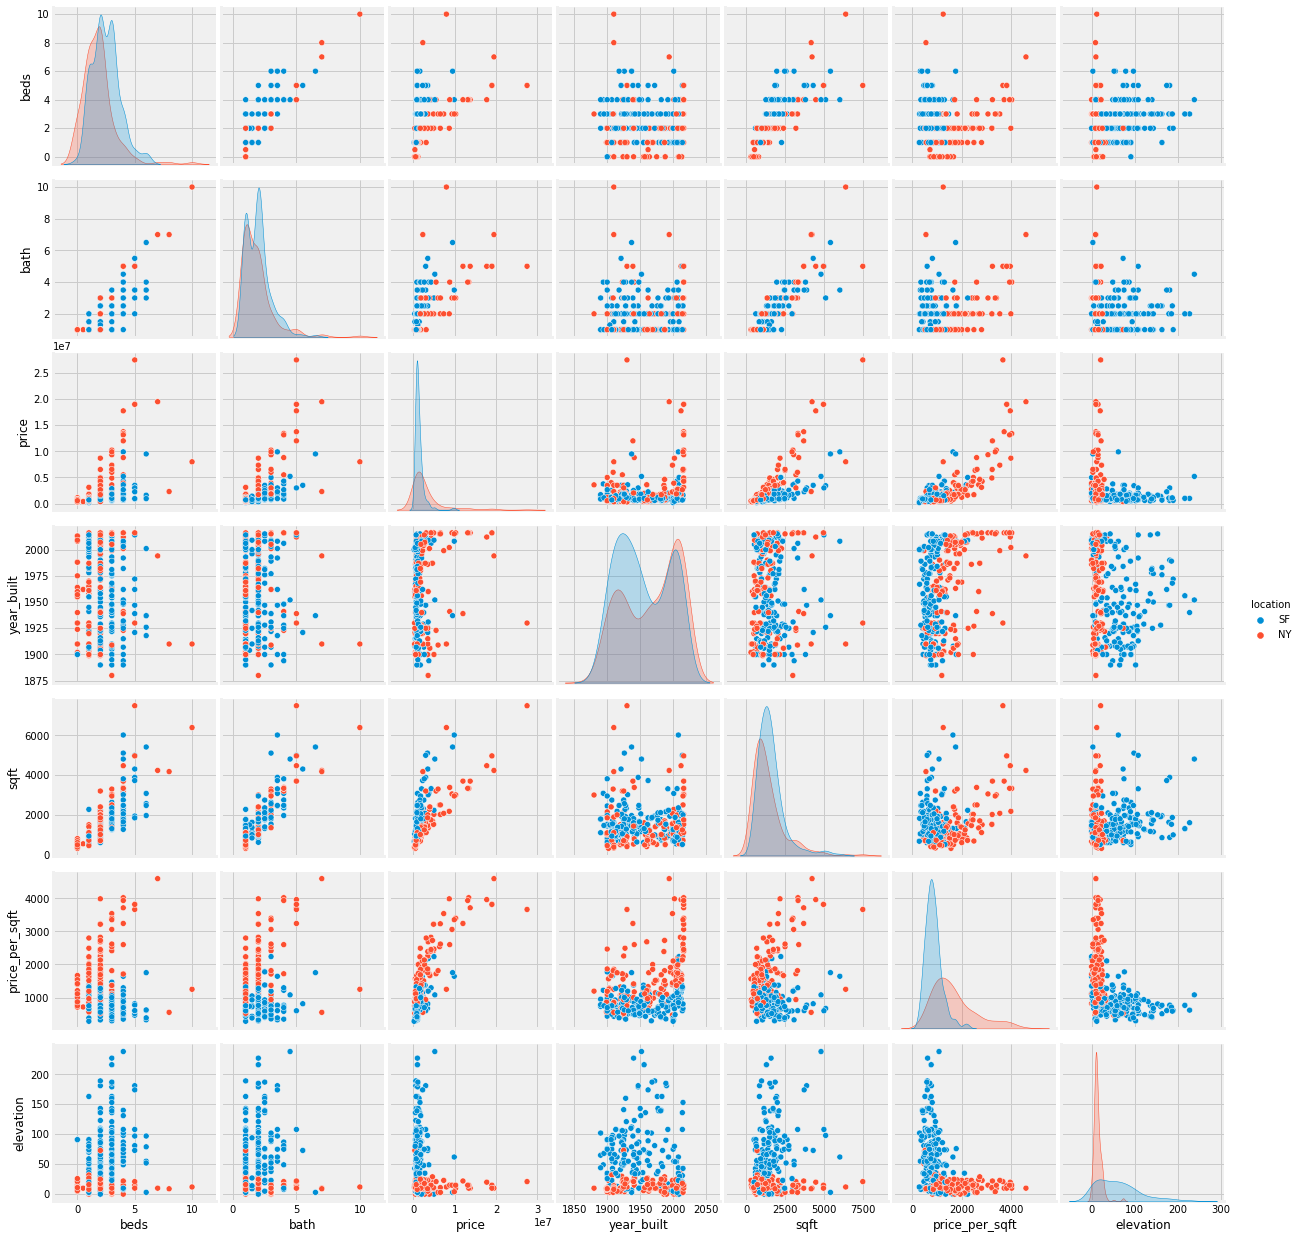

In [30]:
sns.pairplot(train_df, hue='location');

---
**Exercise**: based on the pair plot, which feature do you think will be most predictive / should be the first we choose to model with? 

---


A similar way to visualize a feature's ability to (linearly) separate your data is to look at a boxplot --

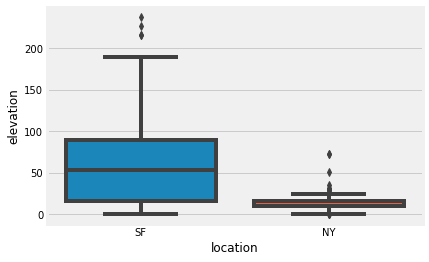

In [31]:
sns.boxplot(x='location', y='elevation', data=train_df);

We see that elevation looks like a very strong feature for distinguishing between SF and NY houses (unsuprising!), and in particular that, based on the above distributions, the higher we go in elevation the increasingly likely it should be that the house is in SF -- if we fit a logistic regression model, we should see a **strong positive coefficient for this feature**.

Analyzing these distributions allows us to see how well any particular feature **linearly separates** the target classes, which is what we're looking for to allow a logistic regression model to perform well (analagous to correlation strengths in linear regression). If such separation isn't really present, a simple coefficient will be an inadequate way to model the relationship between a feature and the target, and more feature engineering / more complex, nonlinear models would be called for.

As a contrasting example, take a look at the year_built feature, where there is much more overlap between the target distributions -- making this feature have **lower predictive signal**. 

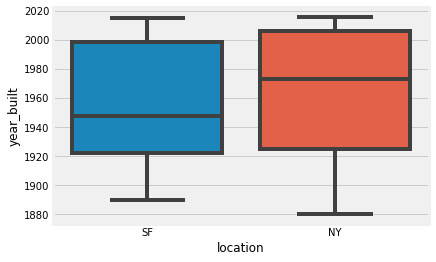

In [32]:
sns.boxplot(x='location', y='year_built', data=train_df);

#### Enter Logistic Regression

Note that **sklearn's logistic regression applies regularization by default**, with the somewhat unintuitive change to a "C" parameter where higher "C" means **less regularization** (as a memorization trick, you can think of C as standing for compleixty - more complexity <-> less regularization.

Because there is only one feature (elevation) that we are looking at right now, applying the standard scaler is superflous, but we'll want to do this with multi-feature logistic models. To keep our results interpretable, we will stay with the unscaled elevation as a feature.

In [33]:
lm1 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm1.fit(X_train[['elevation']], y_train)

LogisticRegression(C=1000)

Sklearn classifiers use accuracy as their default scoring metric, but we'll soon discuss why this metric can be flawed.

In [34]:
lm1.score(X_train[['elevation']], y_train)

0.8040712468193384

Since we're only working with one feature for now, it'll be helpful to build on our understanding by visualizing the model's predictions like we did in the toy default prediction example in section 1. To that end, we'll build out a visualization function with some added frills that allow us to toggle between hard and soft predictions and optionally display the **decision boundary** for the 50% threshold--

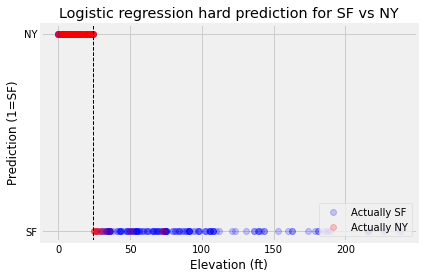

In [40]:
def viz_SF_LR(df, model, hard_classification=True, decision_boundary=False):

    # extract elevation feature and hard or soft predictions
    feature = df[['elevation']].values
    if hard_classification:
        predictions = model.predict(feature)
    else:
        predictions = model.predict_proba(feature)[:, 1] 

    # color filter true class labels and plot predictions
    sf_mask = (df['location'] == 'SF').values
    plt.plot(feature[sf_mask], predictions[sf_mask], 'bo', label='Actually SF', alpha=0.2)
    plt.plot(feature[~sf_mask], predictions[~sf_mask], 'ro', label='Actually NY', alpha=0.2)
    
    # optionally calculate and display decision boundary as dotted line
    if decision_boundary:
        b_0, b_1 = model.intercept_, model.coef_[0]
        plt.gca().axvline(-b_0/b_1,c='k',ls='--',lw=1)
    
    # plot formatting
    plt.ylim(-0.05, 1.05)
    plt.xlabel('Elevation (ft)')
    plt.ylabel('Prediction (1=SF)')
    type_str = 'hard' if hard_classification else 'soft'
    plt.title('Logistic regression ' + type_str + ' prediction for SF vs NY')
    plt.legend(loc='lower right')
    
viz_SF_LR(train_df, lm1, decision_boundary=True)

The logistic regression has found a **decision boundary around 25 ft**: lower than that, the prediction is you are in NY. Higher than that, the model predicts you are in SF. Note that this is the default decision boundary corresponding to 50% probability, and could be manually adjusted if we wanted to be more or less aggressive about predicting positives (it'll be more clear why we might want this once we discuss class imbalance and metrics).

Let's also take a look at the **soft (probability) predictions** -- note that sklearn logistic models have a **predict_proba()** function that returns a 2D array with columns corresponding to the probability of each class outcome, in order. 

In [37]:
lm1.predict_proba([[73],[23],[25]])[:,1] # 2nd column <-> prob class 1

array([0.964748  , 0.48051625, 0.51437561])

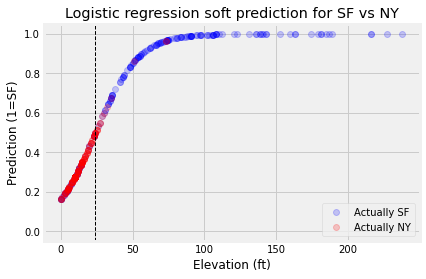

In [41]:
viz_SF_LR(train_df, lm1, hard_classification=False, decision_boundary=True)

As you can see, predicted probabilities become **increasingly confident the farther our feature gets from the decision boundary** (near 0 or 1), and less confident (around 50%) the closer it gets. 

We can also look at the coefficients learned by the model during training, saved as attributes of the model object as we might expect--

In [42]:
lm1.coef_, lm1.intercept_

(array([[0.06774638]]), array([-1.63614128]))

From the math section, we know that the model's predicted probability that a house is in SF is given by:

$$ p(Y=1|X=x) = \frac{1}{1 + e^{  -(\beta_0 + \beta_1 x_1) }}$$

If we set this equation to 50% probability, we can see that $\beta_0 + \beta_1 x_1 = 0$, allowing us to derive a critical point for the elevation level (**find the decision boundary**) that returns 50% probability as below:  

$$0.068*elevation_{crit} - 1.64 = 0 \Rightarrow elevation_{crit} = \frac{1.64}{0.068} \approx 24.1$$

i.e. the decision boundary is at 24.1 ft, as shown in the plot.

Logistic regression model coefficients will always give us **linear equations** that define decision boundaries -- in higher dimensions, the line we see here generalizes to a **dividing hyperplane** that cuts the feature space into 2 parts. This **geometric viewpoint of logistic regression as a linear separator** corresponds very nicely to the geometric viewpoint of linear regression as a "best fit line" described by coefficients -- here, we find the "best separating line" i.e. one which separates the 2 classes as well as possible. 

---

**Exercise**: take a moment to think about what a logistic regression decision boundary might look like for a 2-feature model. Take a look at some of the feature-feature plots in the pairplot above, and try to draw out the boundary.

As an extension, can you imagine/draw a 2-feature dataset where logistic regression would fail to perform well, because of the limitations of its decision boundaries? 

---


#### Cheating

One useful thought experiment is to consider the impact on the model from having much more (i.e. perfectly) separated classes. We'll do this:

- throw out all SF apartments that have elevations less than 24 ft
- throw out all NY apartments that have elevations greater than 24 ft

and check out the impact on coefficients and soft predictions--

In [62]:
# This is to explore a model
# This is NOT legitimate data science!
keep_sf_mask = ((train_df['location'] == 'SF') & (train_df['elevation'] > 24))
keep_ny_mask = ((train_df['location'] == 'NY') & (train_df['elevation'] < 24))
cheat_df = train_df[keep_sf_mask | keep_ny_mask]

lm2 = LogisticRegression(C=1000)
lm2.fit(cheat_df[['elevation']], cheat_df['in_sf'])

In [96]:
lm2.intercept_, lm2.coef_ 

(array([-120.52139418]), array([[4.88276144]]))

Our feature coefficient is much larger than before!

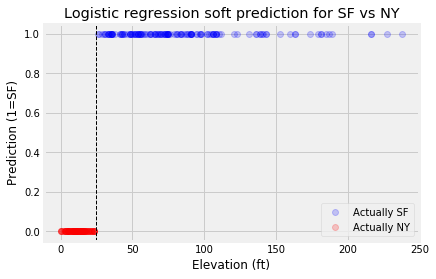

In [97]:
viz_SF_LR(cheat_df, lm2, hard_classification=False, decision_boundary=True)

And even though the decision boundary didn't move much, the model got a lot more certain about the predictions it made! 

#### Extending to 2+ Features

From a theory standpoint, adding more features to our logistic regression model simply means learning a new coefficient in the linear combination for each feature when training -- from another perspective, it means finding a higher dimensional hyperplane that separates the data as well as possible.

Practically, with **sklearn logistic regression we should make sure to scale our features** prior to fitting, since regularzation is used by default (that or set C very high). It can be as simple as the below-- 

In [100]:
std_scale = StandardScaler()

X_train = train_df[['elevation', 'price_per_sqft']]
X_train_scaled = std_scale.fit_transform(X_train)

lm3 = LogisticRegression()
lm3.fit(X_train_scaled, y_train)

y_predict = lm3.predict(X_train_scaled) 
lm3.score(X_train_scaled, y_train)

0.816793893129771

Interesting that we gained so little accuracy from adding a 2nd feature, elevation was really so useful on its own!

---

**Exercise**: fit a logistic regression model on all the features in this housing data. What's your train data accuracy?

---


In [ ]:
## YOUR WORK HERE -- remember to scale!

---

**Exercise at home**: explore fitting a one-versus-rest logistic regression model with sklearn on the Iris dataset -- we'll get you started with a pairplot. Hint: the code needed is essentially exactly the same as for the binary case!

---

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


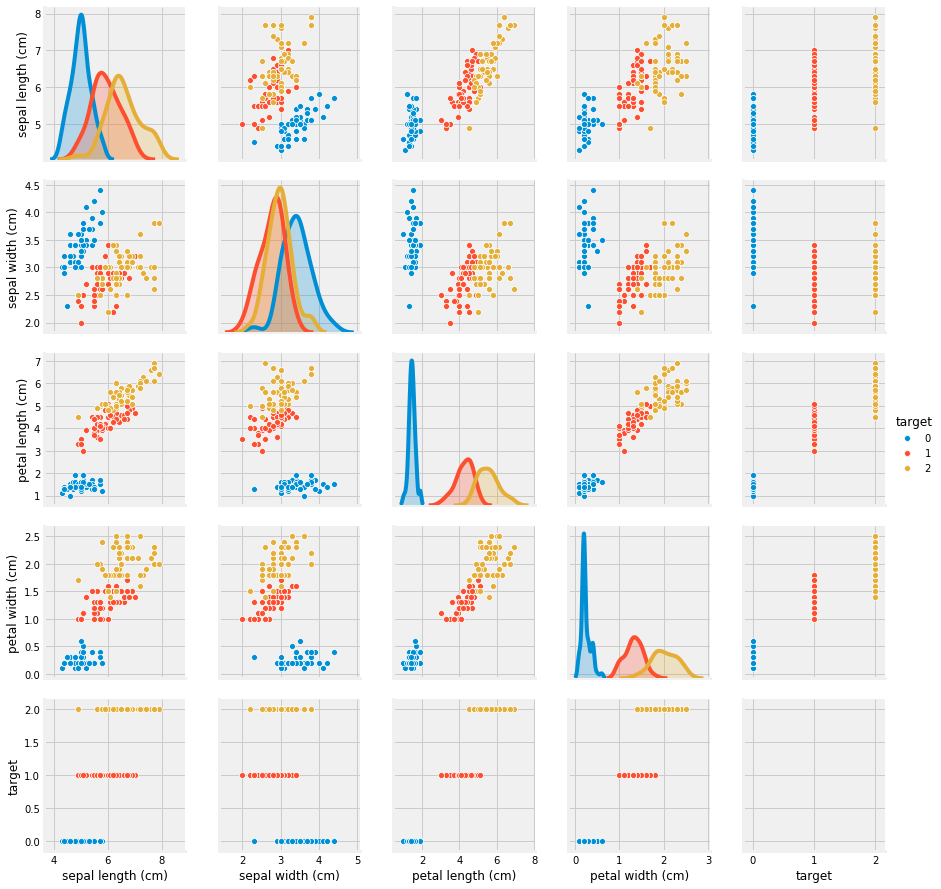

In [106]:
from sklearn import datasets

iris_data  = datasets.load_iris()
iris_df = pd.DataFrame(iris_data['data'])
iris_df.columns = iris_data['feature_names']
iris_df['target'] = iris_data['target']

sns.pairplot(iris_df, hue='target');

### Deeper Theory (optional): Cost Functions, that "C" Parameter, and Generalized Linear Models

#### Cost Function: logistic regression doesn't directly optimize for accuracy

Instead, logistic regression has a cost function (in the binary classification problem) of
$$J_{\text{model}}(\beta) = -\frac{1}{m}\left(\sum_{i=1}^m y_i \ln p_i + (1-y_i) \ln (1-p_i)\right), \quad\quad p_i\text{ function of $\beta$}$$

This is called **cross-entropy loss**. Here $y_i \in \{0,1\}$, so we can tell:
* when $y_i = 1$ (i.e. the house is actually in SF), the contribution is $-\ln p_i$. The closer $p_i$ is to 1, the smaller the cost. If $p_i = 0$ (that is, we claimed it was impossible for this house to be in SF) then we incur an infinite penalty.
* when $y_i = 0$ (i.e. the house is actually in NY), the contribution is $-\ln(1-p_i)$. The closer $p_i$ is to 0, the smaller the penalty. If we claimed $p_i = 1$ (i.e. this house in NY *must* be in SF) then we incur an infinite penalty.

The effect is that we are trying to get the model to optimize the probabilities by giving small cost to those it gets right with high confidence, a medium cost to those it 'waffles' on (i.e. doesn't commit one way or the other), and a high cost to those that it predicts with high confidence but gets wrong.

#### That "C" Parameter

In Linear Regression, we had an $\alpha$ parameter that controlled regularization:
$$J_{\text{linear}} = J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \alpha \sum_{i\neq 0} |\beta_i|^q$$
where $q = 1$ (Lasso) or $q=2$ (Ridge). If $\alpha = 0$ we were effectively turning off regularization. The model cost was generally SSE.

In **Logistic Regression, we have a $C$ parameter that controls the amount of regularization**. We have
$$J_{\text{linear}} = C J_{\text{model}} + J_{\text{regularization}}, \quad\quad\quad J_{\text{regularization}} = \frac{1}{2}\sum_{i\neq 0} |\beta_i|^2 \text{ or } \sum_{i\neq 0} |\beta_i| $$
i.e. the regularization term is always present, and setting $C=0$ turns the model part off (i.e. it doesn't matter how much far off the target your predicted probabilities are). So for logistic regression, high C means "lots of model importance, so regularization's effect is small" whereas low C means "model importance is small, so regularization effect is large". 

I don't know why it is done this way! But again, you can remember this by thinking of **"C" as standing for complexity: higher C is higher complexity <-> less regularization**.

#### Going Even Deeper into Cost: MLEs and GLMs

Maybe you're wondering about a very natural question -- where do these cost functions actually come from? They seem intuitive and convenient enough as summary measures of the quality of a model, but do we just conjure them up out of nothing?

The answer is that **we carefully derive them from probabilistic assumptions** about the data that end up defining a model. In particular, we choose a particular probability distribution to describe the **conditional distribution of the target** $ p(Y=y|X=x) $, and then come up with a way to **link the expected value $E(y|x)$ to the features in our data**, creating a model. 

In linear regression, we choose $ p(Y=y|X=x) \sim N(\mu,\sigma)$ (normal distribution), where $\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_p x_p $.

In logistic regression, we choose $ p(Y=y|X=x) \sim Bernoulli(p) $ (like a biased coin flip), where $p = \frac{1}{1+e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... \beta_p x_p)}} $.

Once we've made these assumptions, we can derive a function called **likelihood** that computes the probability of all the observed data given our assumptions and particular choice of $\beta_i$, and then "train" the model by **choosing $\beta_i$ to maximize this likelihood function**. We often flip this on its head and **choose $\beta_i$ to minimize cost, which is mathematically equivalent to maximizing likelihood**. 

Models that are built according to this formula are **maximum likelihood estimators (MLEs)**, and specific MLEs in which the expectation of the conditional distribution $ p(Y=y|X=x) $ is **linked to a linear combination** of the features are called **generalized linear models (GLMs)**. 

Linear and logistic regression are both examples of a GLM, and another example would be *poisson regression*, where we would model integer count data >= 0 by assuming a poisson distribution.

For more detail on the theory behind MLEs, check out the optional [MLE/GLM primer notebook](../mle-glm/mle_glm_primer.ipynb). 

For an example of deriving linear regression's SSE cost using the MLE framework, check out the optional [linear regression MLE notebook](../mle-glm/linear_regression_mle.ipynb).